In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from signed_distance import *
from mysqp import NLPBuilder, value_and_jacrev, regularized_hess

In [2]:
num_steps = 10
center_obs = jnp.array([0, 0.1])
r_obs = 0.2

dim_robot = 2
r_robot = 0.1
safe_dist = 0.1

q_init = jnp.array([-1, -1])
q_goal = jnp.array([1, 1])
qu, ql = jnp.full(2, 1.1), jnp.full(2, -1.1)

In [3]:
obs = Circle(center_obs, r_obs)
env = EnvSDF((obs,), safe_dist)

In [4]:
#util functions
def to_mat(x):
    return x.reshape(-1, dim_robot)
def to_vec(mat):
    return mat.flatten()
def at_timestep(i, x):
    return to_mat(x)[i]
def to_vel(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

In [5]:
from functools import partial

# functions
def min_dist_cost(x):
    v = to_vel(x)
    return v @ v
state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)
penetration = lambda x: env.penetrations(to_mat(x))

In [6]:
xl = jnp.tile(ql, num_steps)
xu = jnp.tile(qu, num_steps)
x0 = jnp.linspace(q_init, q_goal, num_steps).flatten()

In [7]:
dim = num_steps * dim_robot
nlp = NLPBuilder(dim=dim)
nlp.set_f(min_dist_cost)
nlp.add_eq_const(state_init, q_init)
nlp.add_eq_const(state_goal, q_goal)
nlp.add_eq_const(penetration, 0.)
nlp.set_state_bound(xl, xu)

In [25]:
import scipy.sparse as sparse

get_lag_hess = lambda x, m: regularized_hess(jax.hessian(nlp.get_lagrangian_fn())(x, m))
get_f_val_grad = jax.value_and_grad(nlp.f)
get_g_val_grad = partial(value_and_jacrev, f=nlp.get_g())
get_h_val_grad = partial(value_and_jacrev, f=nlp.get_h())
get_merit = nlp.get_merit_fn()
get_merit_grad = jax.grad(get_merit)
get_merit_direc_deriv = nlp.get_merit_direc_deriv_fn()

import osqp
solver = osqp.OSQP()
is_qp_solver_initialized = False

@jdc.pytree_dataclass
class OptState:
    x: Array
    m: Array
    sigma: float
    lag_hess: Array
    f_val: Array
    f_grad: Array
    g_val: Array
    g_jac: Array
    h_val: Array
    h_jac: Array

    def convexify(self):
        # for qp
        P = self.lag_hess
        q = self.f_grad
        A = jnp.vstack([self.g_jac, self.h_jac])
        u = - jnp.hstack([self.g_val, self.h_val])
        l = - jnp.hstack([self.g_val, jnp.ones_like(self.h_val)*jnp.inf])
        # P = sparse.csc_matrix(P)
        # q = np.asarray(q)
        # A = sparse.csc_matrix(A)
        # l = np.asarray(l)
        # u = np.asarray(u)
        return P, q, A, l, u

def backtrack(
    state:OptState, direction: Array, 
    alpha=1., beta=0.5, gamma=0.1, max_iter=20
):
    x, sigma = state.x, state.sigma
    for i in range(max_iter):
        curr_merit = get_merit(x, sigma)
        next_merit = get_merit(x + alpha * direction, sigma)
        armijo = gamma * alpha * get_merit_direc_deriv(x, direction, sigma)
        if next_merit < curr_merit + armijo:
            break
        alpha *= beta
    return alpha

In [26]:
#state init
x = x0.copy()
m = jnp.zeros(nlp.const_dim)
sigma = 0.1

In [27]:
# function evaluation
lag_hess = get_lag_hess(x, m)
f_val, f_grad = get_f_val_grad(x)
g_val, g_jac = get_g_val_grad(x)
h_val, h_jac = get_h_val_grad(x)

state = OptState(x, m, sigma,
                 lag_hess, f_val, f_grad, g_val, g_jac, h_val, h_jac)

In [28]:
from jaxopt import BoxOSQP
P, q, A, l, u = state.convexify()

qp = BoxOSQP()

In [55]:
%timeit jax.jit(qp.run)(params_obj=(P, q), params_eq=A, params_ineq=(l, u)).params

932 ms ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
print(sol.primal[1])

[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -5.88334680e-01 -9.15977434e-05 -1.12413545e-05 -1.17022365e-01
 -1.17028449e-02 -2.34012902e-01 -2.34026536e-02 -3.51089358e-01
 -3.51117924e-02 -4.68288839e-01 -4.68336083e-02 -5.85646510e-01
 -5.85709438e-02 -4.39087093e-01 -4.39155325e-02 -2.92703092e-01
 -2.92761587e-02 -1.46471903e-01 -1.46502713e-02 -3.11340962e-04
 -2.81356424e-05  9.15977434e-05  1.12413545e-05  1.17022365e-01
  1.17028449e-02  2.34012902e-01  2.34026536e-02  3.51089358e-01
  3.51117924e-02  4.68288839e-01  4.68336083e-02  5.85646510e-01
  5.85709438e-02  4.39087093e-01  4.39155325e-02  2.92703092e-01
  2.92761587e-02  1.46471903e-01  1.46502713e-02  3.11374664e-04
  2.81356424e-05]


In [34]:
sol.primal

(Array([9.15977434e-05, 1.12413545e-05, 1.17022365e-01, 1.17028449e-02,
        2.34012902e-01, 2.34026536e-02, 3.51089358e-01, 3.51117924e-02,
        4.68288839e-01, 4.68336083e-02, 5.85646510e-01, 5.85709438e-02,
        4.39087093e-01, 4.39155325e-02, 2.92703092e-01, 2.92761587e-02,
        1.46471903e-01, 1.46502713e-02, 3.11340962e-04, 2.81356424e-05],      dtype=float32),
 Array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -5.88334680e-01, -9.15977434e-05, -1.12413545e-05, -1.17022365e-01,
        -1.17028449e-02, -2.34012902e-01, -2.34026536e-02, -3.51089358e-01,
        -3.51117924e-02, -4.68288839e-01, -4.68336083e-02, -5.85646510e-01,
        -5.85709438e-02, -4.39087093e-01, -4.39155325e-02, -2.92703092e-01,
        -2.92761587e-02, -1.46471903e-01, -1.46502713e-02, -3.11340962e-04,
        -2.81356424e-05,  9.15977434e-05,  1.12413545e-05,  1.17022365e-01,
         1.17028449e-02,  2.34012902e-01,  2.34026536e-02,  3.51089358e-01,
         3

In [18]:
P, q, A, l, u = state.convexify()
if not is_qp_solver_initialized:
    opts = {"verbose":True, "warm_start":False}
    solver.setup(P, q, A, l, u, **opts)
    is_qp_solver_initialized = True
else:
    solver.update(Px=P.data, q=q, Ax=A.data, l=l, u=u)
res = solver.solve()
if res.info.status != "solved":
    print("QP infeasible!")
else:
    print("QP solved")

iter   objective    pri res    dua res    rho        time
   1  -1.4863e-02   5.16e-01   5.21e+01   1.00e-01   1.44e-04s
 200  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   3.78e-04s
 400  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   6.38e-04s
 600  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   8.33e-04s
 800  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   1.03e-03s
1000  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   1.24e-03s
1200  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   1.44e-03s
1400  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   1.65e-03s
1600  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   1.85e-03s
1800  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   2.05e-03s
2000  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   2.25e-03s
2200  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   2.45e-03s
2400  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   2.65e-03s
2600  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   2.84e-03s
2800  -6.5443e+00   1.23e+00   3.20e+00   1.00e-01   3.04e-0

In [12]:
direction = res.x
alpha = backtrack(state, direction)

In [13]:
#update
x = state.x + alpha * direction
m = state.m * (1-alpha) + alpha * res.y
sigma = jnp.max(jnp.abs(jnp.hstack([1.01*res.y, sigma])))
state_prev = state

In [14]:
def draw_scene(x):
    xs = to_mat(x)
    fig, ax = plt.subplots(figsize=[5,4])
    robots = []
    for q in xs:
        circle = plt.Circle(q, r_robot, color='k')
        robots.append(circle)
        ax.add_patch(circle)
    circle = plt.Circle(center_obs, r_obs, color='r')
    ax.add_patch(circle)
    ax = plt.scatter(*xs.T)

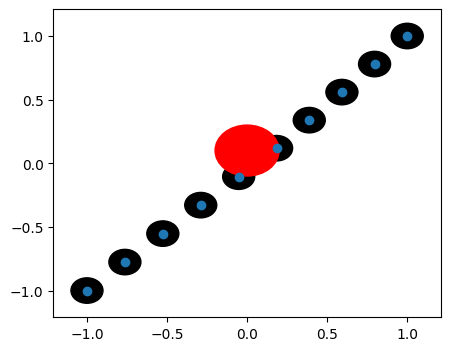

In [16]:
draw_scene(x)